In [15]:
import torch 
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch import nn
from pytorch_lightning import LightningModule, Callback
from torchmetrics import Accuracy
from torchdiffeq import odeint_adjoint as odeint
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from math import pi as pi
import numpy as np
import os
from torch.utils import data
from scipy.integrate import odeint as odeint_sym
import math
import torch.linalg as linalg
import torch.autograd.functional as AGF
from lightning.pytorch.utilities import grad_norm

device = torch.device('cuda',index=2) 

In [16]:
def pendulum(z, t):  # define the ode function
    z1, z2 = z
    dz1 = z2
    g = 9.81
    beta = 0.1
    real_l = 0.5
    dz2 = -(g/real_l)*np.sin(z1)- (beta/0.15*(real_l**2))*z2
    dz = np.array([dz1, dz2])
    return dz

t_i = 0 
t_end = 30.0 
n_steps = 100 
time_vector = np.linspace(t_i, t_end, n_steps)

initial_positions_vector = np.random.uniform(low=-pi/2.0, high=pi/2.0, size=(1,1))
initial_velocity_vector  = pi/180.0*np.random.randn(1,1)
z0_vector = np.concatenate((initial_positions_vector,initial_velocity_vector),axis=1)
print(z0_vector[0])
z_temp = odeint_sym(pendulum, z0_vector[0], time_vector)


[-0.2301793   0.00824562]


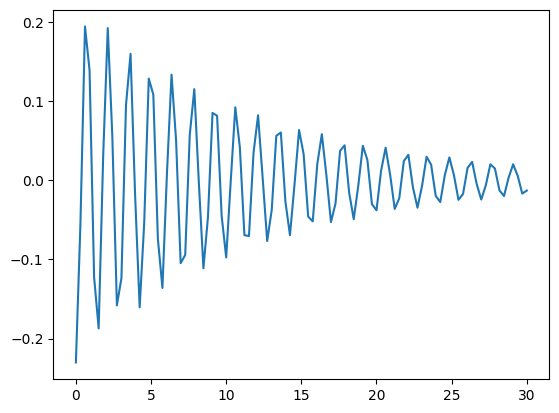

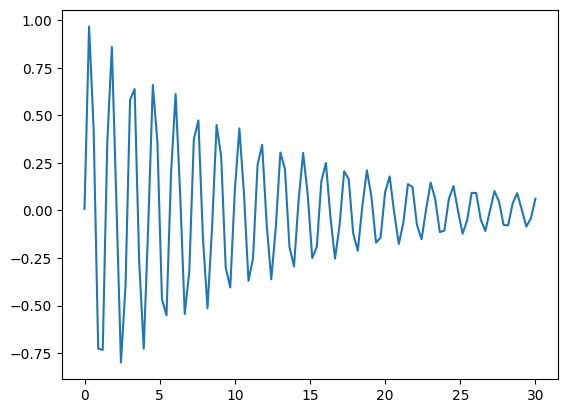

-0.01294404180776431


In [17]:
plt.figure()
plt.plot(time_vector, z_temp[:,0])

plt.figure()
plt.plot(time_vector, z_temp[:,1])
plt.show()

print(z_temp[-1,0])

### Defining the controller

In [18]:
class Controller(nn.Module):

    def __init__(self):
        super(Controller, self).__init__()

        self.dim = 32
        self.fc1 = nn.Linear(2,self.dim, bias = None)
        self.fc2 = nn.Linear(self.dim,self.dim, bias = None)
        self.fc3 = nn.Linear(self.dim,1,bias = None)
        # self.K = nn.Parameter(torch.rand(1,2))
        # print(self.K)
        self.K = nn.Parameter(torch.tensor([[-5.0, -5.0]]))

        # my_init_weight = -1.0*torch.eye(self.dim)
        # with torch.no_grad():
        # #     
        #         self.fc2.weight.copy_(my_init_weight)
    
    def smooth_leaky_relu(self, x):
        alpha = 0.3
        return alpha*x+(1 - alpha) * torch.log(1+torch.exp(x))
    
    def forward(self,x):
        z =  self.K @ x.T
        # print("shape of z", z.shape)
        x = self.smooth_leaky_relu(self.fc1(x))
        x = self.smooth_leaky_relu(self.fc2(x))
        x = self.smooth_leaky_relu(self.fc3(x))
        # print("shape of x", x.shape)
        return x + z
    
   


tensor([[  0.0000],
        [-20.0474]], device='cuda:2', grad_fn=<StackBackward0>)


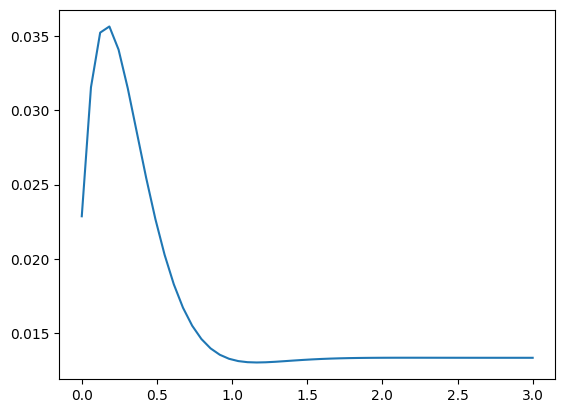

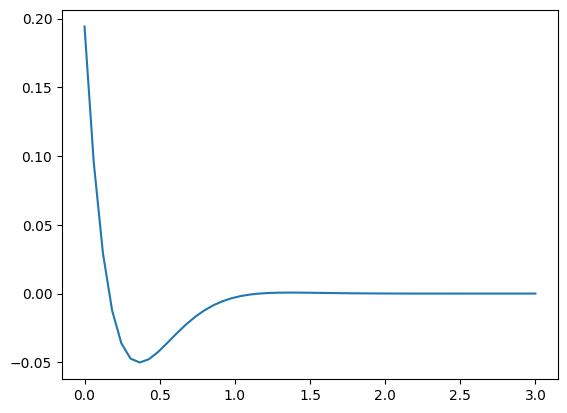

In [19]:
tol = 1e-7 
endtime = 3.0


controller = Controller().to(device)

class closed_loop(nn.Module):

    def __init__(self, controller):
        super(closed_loop, self).__init__()
        self.controller = controller
        self.g = torch.tensor([9.81]).to(device)
        self.beta = torch.tensor([0.1]).to(device)
        self.real_l = torch.tensor([0.5]).to(device)
        self.omega = torch.abs(torch.sqrt(self.g/self.real_l)).to(device)
 
    def forward(self,t, z):
        u = controller(z.T)
        z1, z2 = z
        dz1 = z2
        dz2 = -(self.g/self.real_l)*torch.sin(z1)- (self.beta/0.15*(self.real_l**2))*z2 + (1.0/0.15*(self.real_l**2))*u.squeeze(-1)
        # dz2 = self.omega*self.omega*torch.sin(z1)-self.beta*z2 + u.squeeze(-1)
        # dz =  torch.cat((dz1, dz2), dim=0).reshape(2,1) 
        dz =  torch.stack((dz1,dz2))
        return dz

closed_loop_pendulum = closed_loop(controller).to(device)
x_star = torch.tensor([[torch.pi/4],[0]]).to(device)
print(closed_loop_pendulum(0.0,x_star))
x0 = torch.rand(2,1).to(device)
time_vec = torch.linspace(0,endtime,50).to(device)
out = odeint(closed_loop_pendulum, x0, time_vec, rtol=tol, atol=tol, method="rk4")

plt.figure()
plt.plot(time_vec.cpu(), out[:,0,:].cpu().detach().numpy())

plt.figure()
plt.plot(time_vec.cpu(), out[:,1,:].cpu().detach().numpy())
plt.show()

# Defining the handlers

In [20]:
def func1(L,U,W):
    """
    This function calculates the lower  \tilde{L} and upper bounds  \tilde{U} of W \times Q, given the element-wise upper bound matrix U and
    lower bound matrix L of Q, and the matrix W
    """
    W_plus_mask = torch.where((W > 0), 1.0, 0.0).to(device)
    W_minus_mask = torch.where((W < 0), 1.0, 0.0).to(device)
    W_plus = W_plus_mask.to(device)  * W.to(device) 
    W_minus = W_minus_mask.to(device)  * W.to(device)

    L_tilde = W_plus @ L + W_minus @ U
    U_tilde = W_plus @ U + W_minus @ L
    return L_tilde, U_tilde


def func2(L_tilde, U_tilde,a,b):
    """
    This function calculates the lower \hat{L} and upper bounds \hat{U} of J \times P, where P is an arbitrary matrix. Given the
    element-wise upper bound matrix  \tilde{U} and lower bound matrix  \tilde{L} of P, and a, b.
    """
    # 0 < a < b 
    mask1 = torch.where( ((U_tilde > L_tilde ) | (U_tilde == L_tilde ))  & (L_tilde >= 0),1.0, 0.0 ).to(device)
    mask2 = torch.where(  (U_tilde >= 0) & (L_tilde<=0),1.0, 0.0 ).to(device)
    mask3 = torch.where(  ( U_tilde<=0) & ((U_tilde == L_tilde)|(U_tilde > L_tilde)), 1.0, 0.0 ).to(device)
    # print(mask1 + mask2 + mask3)
    L_hat = a*mask1*L_tilde + b*mask2*L_tilde + b*mask3*L_tilde
    U_hat = b*mask1*U_tilde + b*mask2*U_tilde + a*mask3*U_tilde
    
    
    return L_hat, U_hat

# Pytorch Lightening classifier

In [21]:

from torch.optim.optimizer import Optimizer


class ImageClassifier(LightningModule):
    def __init__(self, regularizer_weight,reg_flag, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = controller
        self.reg_flag = reg_flag
        self.regularizer_weight = regularizer_weight
        self.lr = lr
        self.training_step_outputs = []
        self.real_l = torch.tensor([0.5]).to(device)

        self.loss_func =  nn.MSELoss()
        self.U_dF = torch.tensor([[0.0, 1.0],[16.0,-1.5]]).to(device)

    # def on_before_optimizer_step(self, optimizer: Optimizer) -> None:

    #     norms = grad_norm(self.net, norm_type=2)
    #     self.log_dict(norms) 
    #     print(norms)
    #     return None
        
    

    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr, eps=1e-2)
        # optimizer = torch.optim.AdamW(self.net.parameters(), lr=1e-2)
        
        return [optimizer]

    def regularization(self):
            # L = torch.eye(self.net[0].odefunc.hidden_layers[0].weight.shape[0]).to(device)
            # U = torch.eye(self.net[0].odefunc.hidden_layers[0].weight.shape[0]).to(device)
            g = torch.tensor([[0.0],[(1.0/0.15*(self.real_l**2))]]).to(device)
            # define the constants
            K_linear = self.net.K
            kappa_1 = 0.3
            kappa_2 = 1.0
            cont = g @ K_linear
            XX = self.U_dF + self.U_dF.T + cont + cont.T
            eigenvalues, _ = torch.linalg.eig(XX)

            max_eigenvalue = torch.max(torch.real(eigenvalues))
            # print(XX)
            lambda_max_f = max_eigenvalue #;  0.0332 
            rho = 0.01 + lambda_max_f# contarction rate
            

            
            x_star = torch.tensor([[torch.pi/4],[0]],requires_grad=True,
                              dtype=torch.float32).to(device)
        #     equilibrium_grad = AGF.jacobian(lyapunov_fcn, torch.stack((q_star, p_star)), create_graph=True)
            
            equilibrium_assignment = torch.norm(closed_loop_pendulum(0.0,x_star).to(device))

        # # ! I can require the hessian to be greater than a*I, to improve the positiveness of hessian
        #     equilibrium_hessian = AGF.hessian(lyapunov_fcn, torch.stack((q_star, p_star)), create_graph=True)-0.5*torch.eye(2).to(self.device)

        #     minimum_condition = F.relu(-torch.min(torch.real(linalg.eigvals(equilibrium_hessian))))


            # print(self.net[0].odefunc.weight) ma chère  t'es la(e) meilleur(e)
            # Calculating the lower and upper bound
            L = torch.eye(self.net.fc1.weight.shape[1]).to(device)
                    # print("L shape", L.shape)
            U = torch.eye(self.net.fc1.weight.shape[1]).to(device)

            for name, param in self.net.named_parameters():
                if 'weight' in name:
                
                
                    weights = param.to(device)
                    
                    # print("U shape", U.shape)
                    L_tilde, U_tilde = func1(L,U,weights)
                    # print("L_tilde shape", L_tilde.shape)
                    # print("U_tilde shape", U_tilde.shape)
                    L_hat, U_hat = func2(L_tilde, U_tilde,a=kappa_1,b=kappa_2)
                    # print("L_hat shape", L_hat.shape)
                    # print("U_hat shape", U_hat.shape)
                    L = L_hat
                    U = U_hat
                    # print(L.shape)
                    # print(U.shape)
                
            L_tilde, U_tilde = func1(L,U,g)
            L = L_tilde
            U = U_tilde
            sum_off_U = torch.sum(torch.abs(U),dim =1) - torch.abs(torch.diag(U,0))
            sum_off_L = torch.sum(torch.abs(L),dim =1) - torch.abs(torch.diag(L,0))
          
            offdiag =  rho + 2*torch.diagonal(U, 0) + torch.maximum(sum_off_U, sum_off_L)

            leaky_ = torch.nn.LeakyReLU(negative_slope=0.005)
         
            reg = torch.relu(offdiag.mean()) #+ torch.relu(offdiag_2.max())
            # reg = leaky_(offdiag.max())
            # reg = rho + torch.max(2*torch.diagonal(U, 0) + torch.maximum(sum_off_U, sum_off_L))

            

            return reg +  equilibrium_assignment

    def training_step(self, batch):
        
      
        
        loss = self.regularization()
        self.training_step_outputs.append(loss)
       
        self.log('train_loss', loss, prog_bar=True)
        return loss

    

    # def test_step(self, batch, batch_idx):

    #     local_x0s, local_ys = batch
    #     local_ys = torch.permute(local_ys, [1, 0, 2])
    #     actual_batch_size = local_x0s.shape[0]
    #     # print("shape of x0", local_x0s.shape)
    #     # print("shape of output", local_ys.shape)
    #     x_sim = self.net[0].node_propagation(local_x0s) 
    #     # print("shape of x_sim", x_sim.shape)
    #     test_loss = self.loss_func(x_sim, local_ys)
    #     self.log("test_loss", test_loss, prog_bar=True)
    #     return test_loss

# Define Trainer and dummy dataset

In [26]:
# Need a dummy data set for the pytorch lightening module  
from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from torch.optim import Optimizer


if __name__ == '__main__':

    class MetricTracker(Callback):

        def __init__(self):
            self.collection = []
        
        def on_before_optimizer_step(self, trainer: Trainer, pl_module: LightningModule, optimizer: Optimizer) -> None:
            return super().on_before_optimizer_step(trainer, pl_module, optimizer)
        
        def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
            epoch_mean = torch.stack(pl_module.training_step_outputs)
            pl_module.log("training_epoch_mean", epoch_mean)
            self.collection.append(epoch_mean)
        # free up the memory
            pl_module.training_step_outputs.clear()

    # do whatever is needed

    class TrainDataset(Dataset):
        def __init__(self, q_range, p_range):

            grid_q, grid_p = torch.meshgrid(
                q_range, p_range)

            self.q_data = grid_q.reshape(-1,)
            self.p_data = grid_p.reshape(-1,)

        def __len__(self):
            return len(self.q_data)

        def __getitem__(self, idx):

            return self.q_data[idx], self.p_data[idx]
        
    cb = MetricTracker()
    training_data = TrainDataset(
        torch.linspace(1/4-2, 1/4+2, 1), torch.linspace(-2, 2, 1))

    train_dataloader = DataLoader(
        training_data, batch_size=1, num_workers=30, persistent_workers=True)

    global_data_size = 1
    global_max_epochs = 1000

    torch.set_float32_matmul_precision('medium')

    model = ImageClassifier(reg_flag =True, 
                            regularizer_weight= 1.0,
                            lr = 1e-3)

    trainer = pl.Trainer(accelerator='gpu',  devices= [2],num_nodes=1,
                         max_epochs=global_max_epochs,callbacks=[cb])

    
    trainer.fit(model, train_dataloader)
    trainer.save_checkpoint("/home/mzakwan/ACC2023/controller_pendulum_ident.ckpt")


    # print(trainer.logged_metrics)
    # print(cb.collection)
    # ans = [x.detach().cpu().float() for x in cb.collection]
    # print(ans)



    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | net       | Controller | 1.1 K 
1 | loss_func | MSELoss    | 0     
-----------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


/home/mzakwan/.local/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


/home/mzakwan/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/mzakwan/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


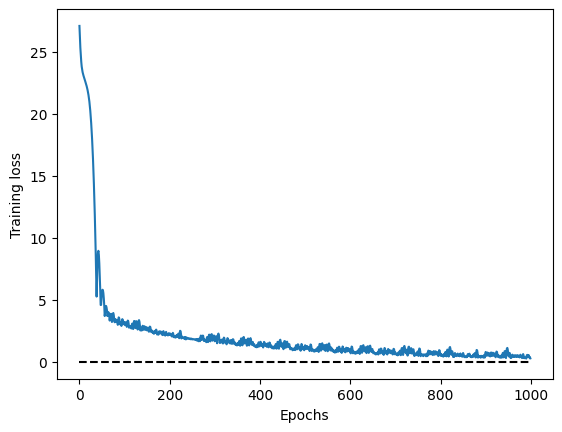

In [23]:
x = torch.arange(0,global_max_epochs)
ans = [x.detach().cpu().float() for x in cb.collection]
fig = plt.figure(5)
plt.plot(x,ans)
plt.plot(x, torch.ones_like(x)*0.0, 'k--')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()
fig.savefig('/home/mzakwan/ACC2023/Training_loss_pendulum.pdf')


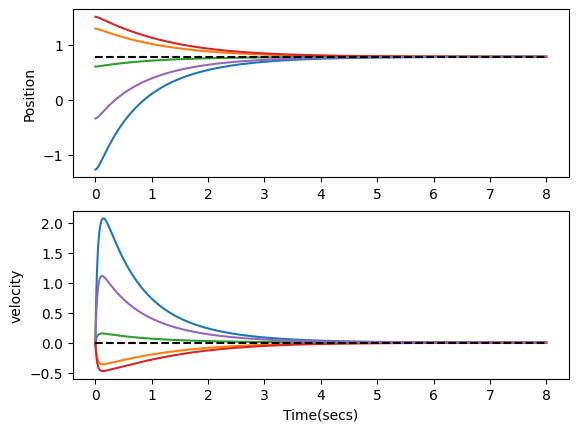

In [24]:


class closed_loop(nn.Module):

    def __init__(self, controller):
        super(closed_loop, self).__init__()

        self.controller = controller
        self.g = torch.tensor([9.81]).to(device)
        self.beta = torch.tensor([0.1]).to(device)
        self.real_l = torch.tensor([0.5]).to(device)
        self.omega = torch.abs(torch.sqrt(self.g/self.real_l)).to(device)
        self.lqr = torch.tensor([   17.2286   , 5.4393]).to(device)
 
    def forward(self,t, z):
        u = controller(z.T)
        u_lqr = self.lqr @ z
        z1, z2 = z
        dz1 = z2
        dz2 = -(self.g/self.real_l)*torch.sin(z1)- (self.beta/0.15*(self.real_l**2))*z2 + (1.0/0.15*(self.real_l**2))*u.squeeze(-1) - (1.0/0.15*(self.real_l**2))*u_lqr*0
        # dz2 = self.omega*self.omega*torch.sin(z1)-self.beta*z2 + u.squeeze(-1)
        # dz =  torch.cat((dz1, dz2), dim=0).reshape(2,1) 
        dz =  torch.stack((dz1,dz2))
        return dz
        
       
    # def forward(self,t, z):
    #     u = controller(z.T)
    #     u_lqr = self.lqr @ z
    #     # print(u_lqr.shape)
    #     # print(u.shape)
    #     z1, z2 = z
    #     dz1 = z2
    #     dz2 = -self.omega*self.omega*torch.sin(z1)-self.beta*z2 + (1.0/0.15*(self.real_l**2))*u.squeeze(-1) - u_lqr
    #     dz =  torch.cat((dz1, dz2), dim=0).reshape(2,1) 
    #     return dz

closed_loop_pendulum = closed_loop(controller).to(device)
endtime = 8.0
n_exp = 5
time_vec = torch.linspace(0,endtime,int(endtime)*100).to(device)
fig, axs = plt.subplots(2)
for idx in range(0,n_exp):
    # x0 = torch.tensor([[-torch.pi/2],[-torch.pi/4]]).to(device)
    initial_positions_vector = np.random.uniform(low=-pi/2.0, high=pi/2.0, size=(1,1))
    initial_velocity_vector  = pi/180.0*np.random.randn(1,1)
    z0_vector = torch.tensor(np.concatenate((initial_positions_vector,initial_velocity_vector),axis=1).T).to(device).to(torch.float32)
    
    out = odeint(closed_loop_pendulum, z0_vector, time_vec, rtol=tol, atol=tol, method="rk4")
    # print(out.shape)
    axs[0].plot(time_vec.cpu(), out[:,0,:].cpu().detach().numpy())
    axs[1].plot(time_vec.cpu(), out[:,1,:].cpu().detach().numpy())
    # plt.plot()

    # # plt.figure()
    # plt.plot()

axs[0].set(ylabel='Position')
axs[0].plot(time_vec.cpu(), torch.ones_like(time_vec.cpu())*torch.pi/4, 'k--')
axs[1].set(xlabel='Time(secs)', ylabel='velocity')
axs[1].plot(time_vec.cpu(), torch.ones_like(time_vec.cpu())*0.0, 'k--')
fig.savefig('/home/mzakwan/ACC2023/pendulum_at_pi_by_4.pdf')


In [25]:
print(out[-1,0,:])
print(torch.pi/4)

tensor([0.7862], device='cuda:2', grad_fn=<SliceBackward0>)
0.7853981633974483
